In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import os

In [5]:
import json
import os
import cv2
import numpy as np
from matplotlib.patches import Rectangle
from pycocotools import mask as coco_mask
from pycocotools.coco import COCO

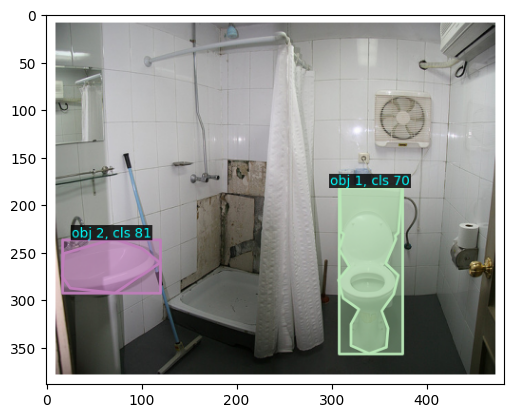

In [3]:
sample = Image.open("sample.jpg")
plt.imshow(sample)

In [33]:
def process_mask(mask):
    
    
    # Get mask
    binary_mask = mask > 0
    mx, my = mask.shape
    overlay = np.zeros((mx,my,3),dtype=np.uint8)
    overlay[binary_mask] = [0, 255, 0]  # Green color for the mask

    # RLE encoding
    rle = coco_mask.encode(np.asfortranarray(binary_mask))
    # Convert `counts` from bytes to string
    rle["counts"] = rle["counts"].decode("utf-8")

    # Decode RLE to calculate area
    area = float(coco_mask.area(rle))

    # Bounding box: [x, y, width, height]
    bbox = coco_mask.toBbox(rle).tolist()

    return rle, area, bbox, overlay

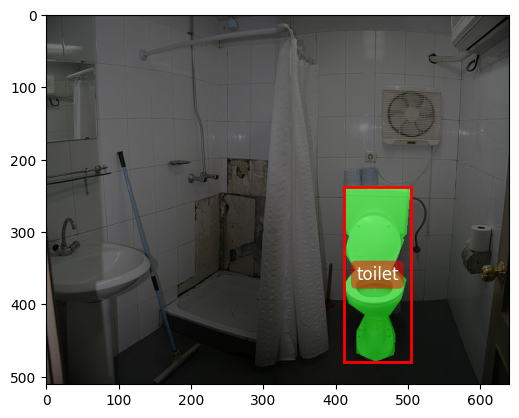

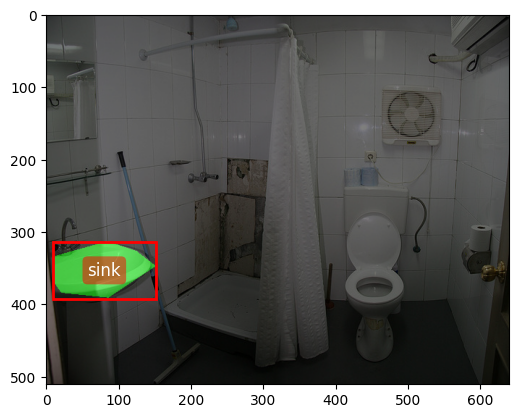

In [36]:


# Paths
annotations_txt = "annotations.txt"
instances_json = "instances_val2017.json"

# Function to decode the RLE mask to a binary mask
def decode_mask(rle):
    return coco_mask.decode(rle)

# Function to plot bounding boxes, masks, and texts
def plot_annotations(image_path, bbox, annotations, category_name):
    # Open the image
    img = Image.open(image_path)
    img = np.array(img)
    
    fig, ax = plt.subplots()
    ax.imshow(img)
    
    # Create a transparent mask overlay
    overlay = np.zeros_like(img, dtype=np.uint8)
    overlay[mask > 0] = [0, 255, 0]  # Green color for the mask
    
    # Overlay the mask on the image with transparency
    alpha = 0.5  # Transparency level
    img_with_overlay = cv2.addWeighted(img, 1 - alpha, overlay, alpha, 0)
    
    # Plot the mask overlay on the image
    ax.imshow(img_with_overlay)

    # Plot the bounding box (Rectangle)
    x, y, w, h = bbox
    rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    # Plot the category name or object ID text at the center of the bounding box
    ax.text(x + w / 2, y + h / 2, category_name, color='white', fontsize=12, ha='center', va='center', 
            bbox=dict(facecolor='red', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.3'))
        


# Load annotations from annotations.txt
annotations = []
image_set = set()
annotation_id = 1  # Unique ID for each annotation
image_id_mapping = {}  # To map image names to IDs

with open(annotations_txt, "r") as f:
    lines = f.readlines()

# Load categories from instances_val2017.json
with open(instances_json, "r") as f:
    instances_data = json.load(f)
categories = instances_data["categories"]

for line in lines[1:]:
    image_name, object_id, category_id, mask_name = line.strip().split(",")
    
    # Assign image_id (unique for each image)
    if image_name not in image_set:
        image_id = len(image_set) + 1
        image_set.add(image_name)
        image_id_mapping[image_name] = image_id

    # Process mask to get RLE, area, and bounding box
    mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
    rle, area, bbox, overlay = process_mask(mask)
    
    annotations.append({
        "id": annotation_id,
        "image_id": image_id_mapping[image_name],
        "category_id": int(category_id),
        "segmentation": rle,  # RLE format
        "area": area,
        "bbox": bbox,
        "iscrowd": 0
    })
    annotation_id += 1

    category_name = next((cat['name'] for cat in categories if cat['id'] == int(category_id)), 'Unknown')

    plot_annotations(image_name, bbox, mask, category_name)
    
plt.show()


